In [1]:
# ===============================================
# Physics-Aware ViT on Paderborn Real (3 classes)
# ===============================================
import os, random, math, time, shutil, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

from transformers import ViTModel, ViTConfig
from transformers.models.vit.modeling_vit import ViTSelfAttention
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================
# CONFIG
# ===============================================
class CFG:
    # --- DATA ---
    data_root   = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"
    output_dir  = r"F:\NeuTech\paderborn code\results"
    classes_keep = ["IR Real", "Normal", "OR Real"]   # folders under data_root
    val_split   = 0.2

    # --- MODEL / TRAIN ---
    model_name   = "google/vit-base-patch16-224-in21k"
    epochs       = 80
    batch_size   = 8
    lr           = 2e-4
    weight_decay = 1e-4
    num_workers  = 0
    pin_memory   = False
    seed         = 42
    num_bands    = 5
    label_smoothing = 0.0   # set 0.05 if a bit overfit

    # --- SYSTEM ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = CFG()
os.makedirs(cfg.output_dir, exist_ok=True)

# Reproducibility
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if cfg.device.type == "cuda":
    torch.cuda.manual_seed_all(cfg.seed)

# ===============================================
# TRANSFORMS
# ===============================================
tf_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.0)),
    transforms.RandomResizedCrop((224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0.0, inplace=True),
])

tf_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ===============================================
# DATASET + STRATIFIED SPLIT (only selected classes)
# ===============================================
base_all = ImageFolder(root=cfg.data_root)
# filter samples to only the expected three classes
keep_idx = [i for i,(p,y) in enumerate(base_all.samples) if base_all.classes[y] in cfg.classes_keep]

samples = [base_all.samples[i] for i in keep_idx]
targets = [base_all.targets[i] for i in keep_idx]
names   = [base_all.classes[t] for t in targets]

# map class names -> contiguous ids 0..C-1
class_names = sorted(cfg.classes_keep)
cls_to_id = {c:i for i,c in enumerate(class_names)}
mapped_targets = [cls_to_id[n] for n in names]

# stratified split indices
from collections import defaultdict
by_cls = defaultdict(list)
for i, t in enumerate(mapped_targets):
    by_cls[t].append(i)

train_ids, val_ids = [], []
for t, idxs in by_cls.items():
    random.shuffle(idxs)
    n_val = max(1, int(round(len(idxs) * cfg.val_split)))
    val_ids += idxs[:n_val]
    train_ids += idxs[n_val:]
random.shuffle(train_ids); random.shuffle(val_ids)

# Build ImageFolder again but with transforms; override internal lists to our filtered samples
train_folder = ImageFolder(root=cfg.data_root, transform=tf_train)
val_folder   = ImageFolder(root=cfg.data_root, transform=tf_val)

# Patch: use the filtered (ordered) subset with our mapped targets
filtered_paths = [samples[i][0] for i in range(len(samples))]
filtered_targets = mapped_targets

train_dataset = Subset(train_folder, train_ids)
val_dataset   = Subset(val_folder,   val_ids)

def collate_fn_preprocessed(batch):
    images, labels = zip(*batch)
    x = torch.stack(images).float()
    if x.ndim == 4 and x.shape[1] == 1:
        x = x.repeat(1,3,1,1)
    y = torch.tensor(labels, dtype=torch.long)
    return {"pixel_values": x, "labels": y}

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                          collate_fn=collate_fn_preprocessed,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False,
                          collate_fn=collate_fn_preprocessed,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("Classes:", class_names)

# ===============================================
# PHYSICS-AWARE ATTENTION
# ===============================================
class BandAwareAttention(ViTSelfAttention):
    def __init__(self, config, num_bands=5):
        super().__init__(config)
        self.band_rel_bias = nn.Parameter(torch.zeros(num_bands, num_bands))
        nn.init.xavier_uniform_(self.band_rel_bias)
        self.band_dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, band_ids=None, **kwargs):
        bsz, seq_len, _ = hidden_states.shape
        query = self.transpose_for_scores(self.query(hidden_states))
        key   = self.transpose_for_scores(self.key(hidden_states))
        value = self.transpose_for_scores(self.value(hidden_states))

        attn_scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.attention_head_size)

        if band_ids is not None:
            if band_ids.dim() == 1:
                band_ids = band_ids.unsqueeze(0).repeat(bsz, 1)
            band_bias = self.band_rel_bias[band_ids][:, :, band_ids]
            band_bias = band_bias.unsqueeze(1)
            attn_scores = attn_scores + band_bias

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.band_dropout(attn_probs)

        context = torch.matmul(attn_probs, value)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_context = context.view(bsz, seq_len, self.all_head_size)
        return new_context, attn_probs

class PhysicsAwareViT(nn.Module):
    def __init__(self, cfg, num_classes, num_bands=5):
        super().__init__()
        vit_cfg = ViTConfig.from_pretrained(cfg.model_name)
        vit_cfg.num_labels = num_classes
        self.vit = ViTModel.from_pretrained(cfg.model_name, config=vit_cfg)
        self.hidden = vit_cfg.hidden_size
        self.num_bands = num_bands

        for blk in self.vit.encoder.layer:
            blk.attention.attention = BandAwareAttention(vit_cfg, num_bands=num_bands)

        self.band_embed = nn.Embedding(num_bands, self.hidden)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.hidden),
            nn.Linear(self.hidden, num_classes)
        )

        self.image_size = vit_cfg.image_size
        self.patch_size = vit_cfg.patch_size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.seq_len = self.num_patches + 1

    def forward(self, pixel_values, labels=None, band_ids=None):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        cls_emb = outputs.last_hidden_state[:, 0]
        if band_ids is not None:
            band_emb = self.band_embed(band_ids)   # [B, seq_len, H]
            cls_emb = cls_emb + band_emb.mean(dim=1)
        logits = self.mlp_head(cls_emb)

        if labels is None:
            loss = None
        else:
            if cfg.label_smoothing > 0:
                # simple label smoothing
                n = logits.size(-1)
                with torch.no_grad():
                    true_dist = torch.zeros_like(logits)
                    true_dist.fill_(cfg.label_smoothing / (n - 1))
                    true_dist.scatter_(1, labels.unsqueeze(1), 1 - cfg.label_smoothing)
                loss = torch.mean(torch.sum(-true_dist * F.log_softmax(logits, dim=-1), dim=-1))
            else:
                loss = F.cross_entropy(logits, labels)
        return {"loss": loss, "logits": logits}

# ===============================================
# TRAIN / EVAL UTILITIES
# ===============================================
def generate_band_ids(batch_size, seq_len, num_bands=5):
    n_patches = seq_len - 1
    patch_ids = torch.arange(n_patches) % num_bands
    full = torch.zeros(seq_len, dtype=torch.long)
    full[1:] = patch_ids
    return full.unsqueeze(0).repeat(batch_size, 1)

def accuracy_fn(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_acc, steps = 0.0, 0.0, 0
    for batch in loader:
        x = batch["pixel_values"].to(device)
        y = batch["labels"].to(device)
        band = generate_band_ids(x.size(0), model.seq_len, model.num_bands).to(device)
        out = model(pixel_values=x, labels=y, band_ids=band)
        total_loss += out["loss"].item()
        total_acc  += accuracy_fn(out["logits"], y)
        steps += 1
    return total_loss / steps, total_acc / steps

# ===============================================
# TRAINING LOOP (early-stop + best checkpoint)
# ===============================================
model = PhysicsAwareViT(cfg, num_classes=len(class_names)).to(cfg.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs)
scaler = torch.amp.GradScaler("cuda", enabled=(cfg.device.type == "cuda"))

best_acc, patience, wait = 0.0, 15, 0
best_ckpt = os.path.join(cfg.output_dir, "best_model.pt")
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, cfg.epochs + 1):
    model.train()
    epoch_loss, epoch_acc, steps = 0.0, 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}", leave=False)
    for batch in pbar:
        x = batch["pixel_values"].to(cfg.device)
        y = batch["labels"].to(cfg.device)
        band = generate_band_ids(x.size(0), model.seq_len, model.num_bands).to(cfg.device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=(cfg.device.type == "cuda")):
            out = model(pixel_values=x, labels=y, band_ids=band)
            loss = out["loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        acc = accuracy_fn(out["logits"].detach(), y)
        epoch_loss += loss.item(); epoch_acc += acc; steps += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")

    # epoch metrics
    tr_loss = epoch_loss/steps
    tr_acc  = epoch_acc/steps
    val_loss, val_acc = evaluate(model, val_loader, cfg.device)
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(val_loss);  val_accs.append(val_acc)
    print(f"[{epoch:03d}] train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # checkpoint & early stop
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "classes": class_names,
            "cfg": vars(cfg),
            "curves": {
                "train_losses": train_losses, "val_losses": val_losses,
                "train_accs": train_accs, "val_accs": val_accs,
            }
        }, best_ckpt)
        print(f"  ✅ New best model saved (val_acc={val_acc:.4f})")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping.")
            break

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

# ===============================================
# EVALUATION + PLOTS (CM + ROC + Curves)
# ===============================================
ckpt = torch.load(best_ckpt, map_location=cfg.device)
model.load_state_dict(ckpt["model_state"])
model.eval()

# --- collect val predictions ---
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        x = batch["pixel_values"].to(cfg.device)
        y = batch["labels"].to(cfg.device)
        band = generate_band_ids(x.size(0), model.seq_len, model.num_bands).to(cfg.device)
        out = model(pixel_values=x, labels=None, band_ids=band)["logits"]
        all_logits.append(out.cpu())
        all_labels.append(y.cpu())
all_logits = torch.cat(all_logits, 0)
all_labels = torch.cat(all_labels, 0)
probs = F.softmax(all_logits, dim=1).numpy()
preds = all_logits.argmax(dim=1).numpy()
labels_np = all_labels.numpy()

# --- metrics ---
acc = accuracy_score(labels_np, preds)
print(f"✅ Final Validation Accuracy: {acc*100:.2f}%")
print(classification_report(labels_np, preds, target_names=class_names))

# --- confusion matrix ---
cm = confusion_matrix(labels_np, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, annot_kws={"size":14})
plt.xlabel("Predicted", fontsize=14, fontweight='bold')
plt.ylabel("True", fontsize=14, fontweight='bold')
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.tight_layout()
cm_path = os.path.join(cfg.output_dir, "confusion_matrix.png")
plt.savefig(cm_path, dpi=600)
plt.close()
print(f"✅ Confusion matrix saved at: {cm_path}")

# --- ROC curves (one-vs-rest) ---
num_classes = len(class_names)
y_bin = label_binarize(labels_np, classes=list(range(num_classes)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves (Validation)', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
roc_path = os.path.join(cfg.output_dir, "roc_curves.png")
plt.savefig(roc_path, dpi=600)
plt.close()
print(f"✅ ROC curves saved at: {roc_path}")

# --- Training curves (from checkpoint history) ---
curves = ckpt.get("curves", None)
if curves:
    ep = np.arange(1, len(curves["train_losses"])+1)
    # Accuracy
    plt.figure(figsize=(10,5))
    plt.plot(ep, np.array(curves["train_accs"])*100, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(ep, np.array(curves["val_accs"])*100,   label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    plt.title('Training vs Validation Accuracy', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    acc_plot = os.path.join(cfg.output_dir, "training_val_accuracy.png")
    plt.savefig(acc_plot, dpi=600); plt.close()
    print(f"📈 Accuracy plot saved: {acc_plot}")

    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(ep, curves["train_losses"], label='Training Loss', color='green', linewidth=2)
    plt.plot(ep, curves["val_losses"],   label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    loss_plot = os.path.join(cfg.output_dir, "training_val_loss.png")
    plt.savefig(loss_plot, dpi=600); plt.close()
    print(f"📉 Loss plot saved: {loss_plot}")
else:
    print("ℹ️ No saved curves in checkpoint (older run?). You can still parse console logs to draw curves.")


Train samples: 7137, Val samples: 1785
Classes: ['IR Real', 'Normal', 'OR Real']


[001] train_loss=0.7726, train_acc=0.6156, val_loss=0.5488, val_acc=0.7533
  ✅ New best model saved (val_acc=0.7533)


[002] train_loss=0.5839, train_acc=0.7360, val_loss=0.4633, val_acc=0.7924
  ✅ New best model saved (val_acc=0.7924)


[003] train_loss=0.4451, train_acc=0.7954, val_loss=0.3978, val_acc=0.8147
  ✅ New best model saved (val_acc=0.8147)


[004] train_loss=0.3846, train_acc=0.8239, val_loss=0.3487, val_acc=0.8482
  ✅ New best model saved (val_acc=0.8482)


[005] train_loss=0.3813, train_acc=0.8217, val_loss=0.3201, val_acc=0.8521
  ✅ New best model saved (val_acc=0.8521)


[006] train_loss=0.3215, train_acc=0.8526, val_loss=0.1962, val_acc=0.9029
  ✅ New best model saved (val_acc=0.9029)


[007] train_loss=0.2428, train_acc=0.8870, val_loss=0.2018, val_acc=0.9180
  ✅ New best model saved (val_acc=0.9180)


[008] train_loss=0.2351, train_acc=0.8942, val_loss=0.1374, val_acc=0.9420
  ✅ New best model saved (val_acc=0.9420)


[009] train_loss=0.2913, train_acc=0.8562, val_loss=0.3049, val_acc=0.8722


[010] train_loss=0.1883, train_acc=0.9121, val_loss=0.1150, val_acc=0.9481
  ✅ New best model saved (val_acc=0.9481)


[011] train_loss=0.1858, train_acc=0.9183, val_loss=0.1182, val_acc=0.9464


[012] train_loss=0.1801, train_acc=0.9171, val_loss=0.9440, val_acc=0.4470


[013] train_loss=0.9574, train_acc=0.4605, val_loss=0.9061, val_acc=0.5614


[014] train_loss=0.7534, train_acc=0.6312, val_loss=0.5198, val_acc=0.7706


[015] train_loss=0.2745, train_acc=0.8828, val_loss=0.1322, val_acc=0.9464


[016] train_loss=0.1635, train_acc=0.9309, val_loss=0.1078, val_acc=0.9503
  ✅ New best model saved (val_acc=0.9503)


[017] train_loss=0.1521, train_acc=0.9369, val_loss=0.2054, val_acc=0.9141


[018] train_loss=0.1490, train_acc=0.9338, val_loss=0.1176, val_acc=0.9515
  ✅ New best model saved (val_acc=0.9515)


[019] train_loss=0.1311, train_acc=0.9398, val_loss=0.1141, val_acc=0.9515


[020] train_loss=0.1311, train_acc=0.9457, val_loss=0.1000, val_acc=0.9548
  ✅ New best model saved (val_acc=0.9548)


[021] train_loss=0.1615, train_acc=0.9372, val_loss=0.1397, val_acc=0.9397


[022] train_loss=0.1394, train_acc=0.9432, val_loss=0.1139, val_acc=0.9414


[023] train_loss=0.1208, train_acc=0.9467, val_loss=0.1416, val_acc=0.9269


[024] train_loss=0.1225, train_acc=0.9450, val_loss=0.1136, val_acc=0.9515


[025] train_loss=0.1191, train_acc=0.9507, val_loss=0.0925, val_acc=0.9565
  ✅ New best model saved (val_acc=0.9565)


[026] train_loss=0.1056, train_acc=0.9521, val_loss=0.0993, val_acc=0.9565


[027] train_loss=0.1162, train_acc=0.9492, val_loss=0.0932, val_acc=0.9542


[028] train_loss=0.1099, train_acc=0.9514, val_loss=0.1036, val_acc=0.9531


[029] train_loss=0.0923, train_acc=0.9600, val_loss=0.0741, val_acc=0.9710
  ✅ New best model saved (val_acc=0.9710)


[030] train_loss=0.1141, train_acc=0.9521, val_loss=0.0835, val_acc=0.9710


[031] train_loss=0.0971, train_acc=0.9565, val_loss=0.2076, val_acc=0.9330


[032] train_loss=0.1188, train_acc=0.9504, val_loss=0.0957, val_acc=0.9498


[033] train_loss=0.0984, train_acc=0.9579, val_loss=0.0960, val_acc=0.9615


[034] train_loss=0.0903, train_acc=0.9626, val_loss=0.0846, val_acc=0.9626


[035] train_loss=0.0877, train_acc=0.9619, val_loss=0.0643, val_acc=0.9715
  ✅ New best model saved (val_acc=0.9715)


[036] train_loss=0.0972, train_acc=0.9572, val_loss=0.0606, val_acc=0.9738
  ✅ New best model saved (val_acc=0.9738)


[037] train_loss=0.1003, train_acc=0.9586, val_loss=0.0807, val_acc=0.9615


[038] train_loss=0.0785, train_acc=0.9665, val_loss=0.0511, val_acc=0.9788
  ✅ New best model saved (val_acc=0.9788)


[039] train_loss=0.0965, train_acc=0.9584, val_loss=0.0917, val_acc=0.9542


[040] train_loss=0.1006, train_acc=0.9588, val_loss=0.0864, val_acc=0.9721


[041] train_loss=0.0774, train_acc=0.9686, val_loss=0.1052, val_acc=0.9531


[042] train_loss=0.0711, train_acc=0.9686, val_loss=0.0608, val_acc=0.9727


[043] train_loss=0.0888, train_acc=0.9646, val_loss=0.0491, val_acc=0.9766


[044] train_loss=0.0788, train_acc=0.9667, val_loss=0.0631, val_acc=0.9676


[045] train_loss=0.0796, train_acc=0.9639, val_loss=0.0569, val_acc=0.9771


[046] train_loss=0.0761, train_acc=0.9686, val_loss=0.0887, val_acc=0.9593


[047] train_loss=0.0795, train_acc=0.9675, val_loss=0.0607, val_acc=0.9738


[048] train_loss=0.0756, train_acc=0.9657, val_loss=0.0605, val_acc=0.9727


[049] train_loss=0.0810, train_acc=0.9721, val_loss=0.1389, val_acc=0.9330


[050] train_loss=0.0728, train_acc=0.9700, val_loss=0.0756, val_acc=0.9665


[051] train_loss=0.0778, train_acc=0.9664, val_loss=0.0569, val_acc=0.9738


[052] train_loss=0.0628, train_acc=0.9733, val_loss=0.0468, val_acc=0.9777


[053] train_loss=0.0630, train_acc=0.9731, val_loss=0.0524, val_acc=0.9732
⏹️ Early stopping.
Training complete. Best validation accuracy: 0.9788
✅ Final Validation Accuracy: 97.87%
              precision    recall  f1-score   support

     IR Real       0.97      0.98      0.98       765
      Normal       1.00      1.00      1.00       384
     OR Real       0.98      0.96      0.97       636

    accuracy                           0.98      1785
   macro avg       0.98      0.98      0.98      1785
weighted avg       0.98      0.98      0.98      1785

✅ Confusion matrix saved at: F:\NeuTech\paderborn code\results\confusion_matrix.png
✅ ROC curves saved at: F:\NeuTech\paderborn code\results\roc_curves.png
📈 Accuracy plot saved: F:\NeuTech\paderborn code\results\training_val_accuracy.png
📉 Loss plot saved: F:\NeuTech\paderborn code\results\training_val_loss.png


              precision    recall  f1-score   support

     IR Real       0.97      0.98      0.98       765
      Normal       1.00      1.00      1.00       384
     OR Real       0.98      0.96      0.97       636

    accuracy                           0.98      1785
   macro avg       0.98      0.98      0.98      1785
weighted avg       0.98      0.98      0.98      1785



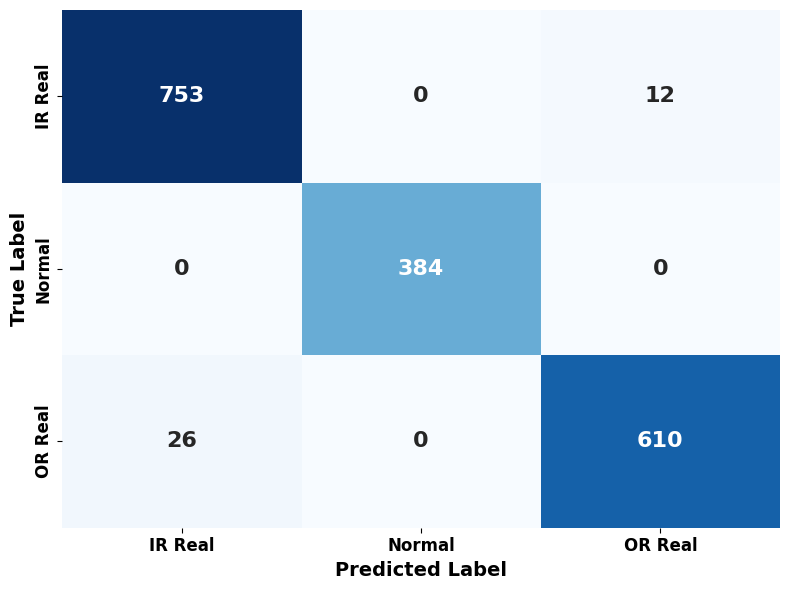

✅ Confusion matrix saved at: F:\NeuTech\paderborn code\results\cm_val.png


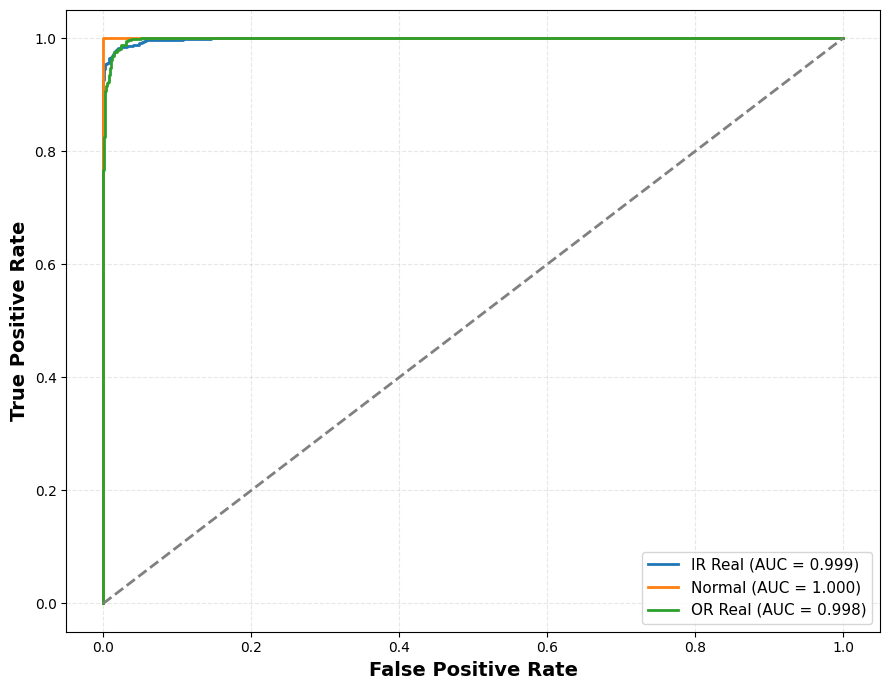

✅ ROC curves saved at: F:\NeuTech\paderborn code\results\roc_val.png


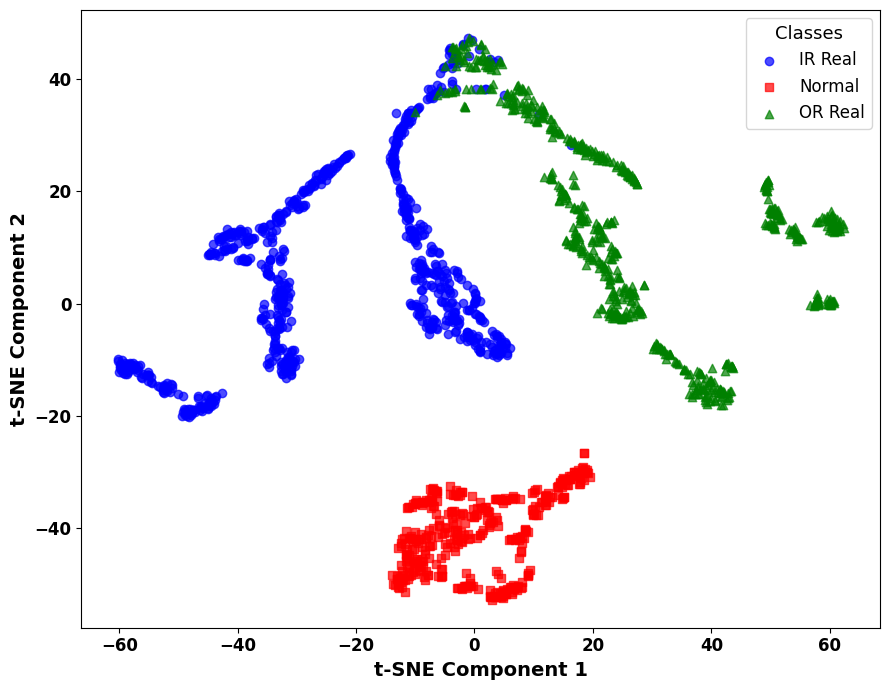

✅ t-SNE plot saved at: F:\NeuTech\paderborn code\results\tsne_features.png


In [2]:
# =========================
# Imports
# =========================
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

# =========================
# Helpers
# =========================
def _gen_band_ids(model, batch_size, device):
    """Create band ids for PhysicsAwareViT; return None for plain models."""
    if hasattr(model, "seq_len") and hasattr(model, "num_bands"):
        ids = torch.zeros(model.seq_len, dtype=torch.long)
        ids[1:] = torch.arange(model.seq_len - 1) % model.num_bands
        return ids.unsqueeze(0).repeat(batch_size, 1).to(device)
    return None

@torch.no_grad()
def _forward_logits(model, x, device):
    """Forward pass that always returns logits (handles dict outputs)."""
    x = x.to(device)
    band_ids = _gen_band_ids(model, x.size(0), device)
    out = model(pixel_values=x, band_ids=band_ids) if band_ids is not None else model(x)
    return out["logits"] if isinstance(out, dict) else out

# =========================
# Confusion Matrix
# =========================
@torch.no_grad()
def plot_confusion_matrix(model, dataloader, class_names, device, save_path):
    model.eval()
    all_labels, all_preds = [], []

    for batch in dataloader:
        x = batch["pixel_values"] if isinstance(batch, dict) else batch[0]
        y = batch["labels"] if isinstance(batch, dict) else batch[1]
        y = y.to(device)

        logits = _forward_logits(model, x, device)
        preds = logits.argmax(dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names,
        cbar=False, annot_kws={"size": 16, "fontweight": "bold"}
    )
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ Confusion matrix saved at: {save_path}")

# =========================
# ROC Curves (OvR)
# =========================
@torch.no_grad()
def plot_roc_curves(model, dataloader, class_names, device, save_path):
    model.eval()
    num_classes = len(class_names)

    all_labels, all_probs = [], []
    for batch in dataloader:
        x = batch["pixel_values"] if isinstance(batch, dict) else batch[0]
        y = batch["labels"] if isinstance(batch, dict) else batch[1]

        logits = _forward_logits(model, x, device)
        probs = torch.softmax(logits, dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(9, 7))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3, linestyle='--')
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ ROC curves saved at: {save_path}")

# =========================
# t-SNE (CLS embeddings)
# =========================
@torch.no_grad()
def extract_cls_features(model, dataloader, device):
    """Grab CLS token features from the last hidden state."""
    model.eval()
    feats, labels = [], []

    for batch in dataloader:
        x = batch["pixel_values"].to(device)
        y = batch["labels"].to(device)

        # Use the backbone to get hidden states
        if hasattr(model, "vit"):  # PhysicsAwareViT
            outputs = model.vit(x, output_hidden_states=True)
        else:  # Plain ViTModel or torch Module returning hidden states
            outputs = model(x, output_hidden_states=True)

        cls = outputs.last_hidden_state[:, 0, :]  # [B, H]
        feats.append(cls.cpu().numpy())
        labels.append(y.cpu().numpy())

    feats = np.concatenate(feats, axis=0)
    labels = np.concatenate(labels, axis=0)
    return feats, labels

def compute_tsne(features, n_components=2, random_state=42, perplexity=30):
    tsne = TSNE(n_components=n_components, random_state=random_state, init='pca', perplexity=perplexity)
    return tsne.fit_transform(features)

def plot_tsne(features_tsne, labels, class_names, save_path):
    plt.figure(figsize=(9, 7))
    # simple palette/markers; extend if you have more classes
    palette = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X']

    for i, cls in enumerate(class_names):
        mask = (labels == i)
        plt.scatter(
            features_tsne[mask, 0], features_tsne[mask, 1],
            label=cls, color=palette[i % len(palette)], marker=markers[i % len(markers)],
            alpha=0.7
        )

    plt.legend(title="Classes", fontsize=12, title_fontsize=13, loc='best', frameon=True)
    plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=800)
    plt.show()
    print(f"✅ t-SNE plot saved at: {save_path}")

# =========================
# Run (use your existing objects)
# =========================
# Assumes you already have: model, val_loader, cfg, and class_names
# If class_names isn't defined, try to get it from your dataset/checkpoint.
# class_names = full_train.classes

cm_path  = os.path.join(cfg.output_dir, "cm_val.png")
roc_path = os.path.join(cfg.output_dir, "roc_val.png")
tsne_path = os.path.join(cfg.output_dir, "tsne_features.png")

# 1) Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, cfg.device, save_path=cm_path)

# 2) ROC Curves
plot_roc_curves(model, val_loader, class_names, cfg.device, save_path=roc_path)

# 3) t-SNE
features, labels_arr = extract_cls_features(model, val_loader, cfg.device)
features_2d = compute_tsne(features, n_components=2, random_state=42, perplexity=30)
plot_tsne(features_2d, labels_arr, class_names, save_path=tsne_path)
